#**Detecting Fake Reviews with Attention**





#*An Attention Layer from Scratch*

We think to ourselves that maybe, instead of having the LSTM figure out a compressed representation of the sequence in a 'fixed' manner, giving fixed 'weighting' or 'attention' to the particular words in a sequence, across observations, we should provide it the flexibility to decide which words more or less important, depending on the joint set of words seen. This 'flexibility' to shift focus depending on the combinations of encountered tokens is exactly what attention seeks to achieve. We are going to implement an attention layer here, from scratch, which receives all the hidden states of the LSTM (rather than just the final hidden state), and it's going to provide the ability to highlight different words when constructing the sequence embedding, depending on the values that are present in the sequence. Here, we need one weight for each dimension of the embedding space that words were cast into. Imagine a 2D latent space, of long vs. short, and noun vs. not noun (or something - I made this up). Our weights might adapt under training to enable our model to focus more on long vs. short words, and nouns versus non-nouns, when formulating its prediction. Obviously, our embedding space captures latent semantic notions that we cannot articulate, but this is what it is doing conceptually. 

Let's reimport and process our dataset as before.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

# Just load the data from the Week 3 folder again.
trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2022/main/Week%203/datasets/deceptive-opinion.csv')
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

# Let's shuffle things... 
shuffled_indices= np.arange(trip_advisor.shape[0])
np.random.shuffle(shuffled_indices)
trip_advisor = trip_advisor.loc[shuffled_indices]

trip_advisor.describe(include='all')

,deceptive,hotel,polarity,source,text
count,1600,1600,1600,1600,1600
unique,2,20,2,3,1596
top,deceptive,hyatt,positive,MTurk,Very disappointed in our stay in Chicago Monoc...
freq,800,80,800,800,2


Let's set aside our labels...

In [2]:
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

Let's make a TextVectorization() layer to preprocess our text.

In [3]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # adding more tokens to allow for increase due to bigrams.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
)

text_vectorization.adapt(trip_advisor['text'])

We are going to start off with one-hot encodings again, just to make sure we understand the shapes of all the tensors and things as we go along, so we understand what the network is doing! 

In [4]:
text_data = trip_advisor['text']
processed_text = text_vectorization(text_data)
one_hot = tf.one_hot(processed_text, depth=2000) # we one-hot encode those, so it becomes a length x2000 vector.

print(one_hot.shape)

(1600, 784, 2000)


Now we can make our network... 

Our LSTM layer produces a tensor of shape (None, 784, 20).
The attention layer then has 20 weights and 1 bias term.
Our attention layer splits out a tensor of shape (None, 784, 1).
Flattening the output of the attention layer produces a tensor of shape (None, 784).
We have now replicated our attention weights, to create a tensor of shape (None, 20, 784).
So, now we have an attention weight matrix that is of shape (None, 784, 20).
Having done that multiplication, we have a tensor of shape (None, 784, 20).
(None, 784)


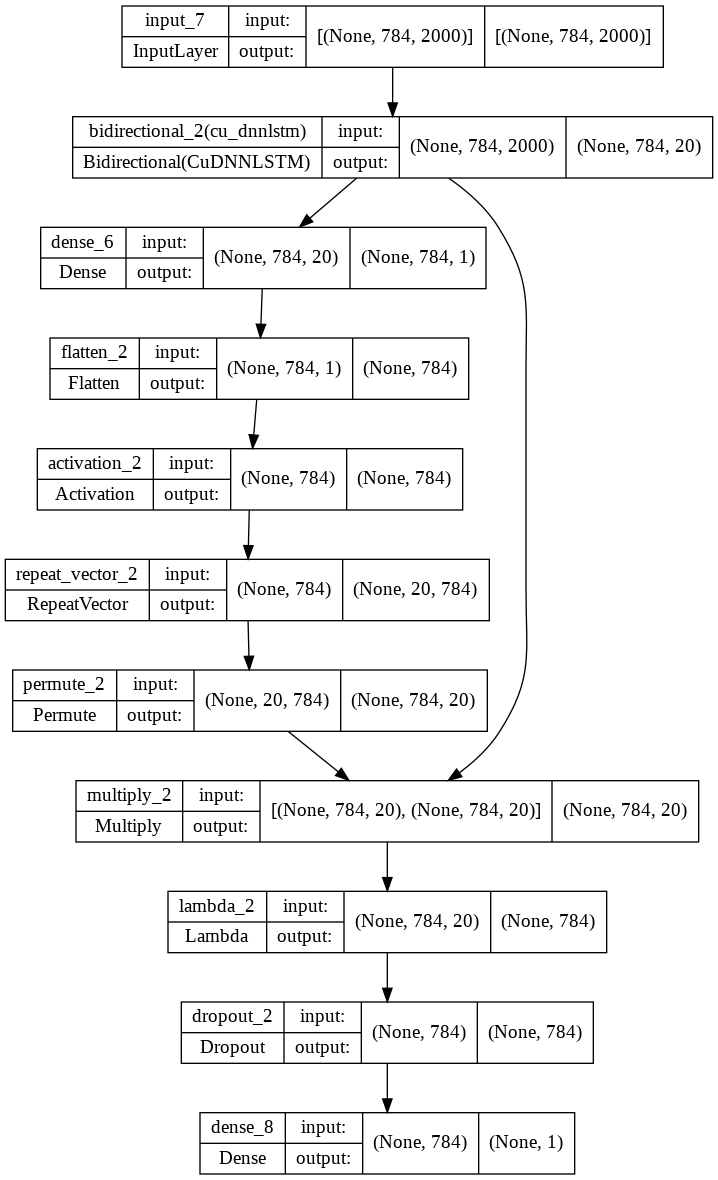

In [13]:
from keras import backend as K
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense, merge, CuDNNLSTM

def build_model():
    # Now, let's start specifying our model... 
    inputs = keras.layers.Input(shape=one_hot.shape[1:]) # We take the sequence of 1-hot encodings as input.

    # The LSTM will yield, for each sequence, a new representation for each element (you can think about these as new 'history-aware' word embeddings)
    # If we have many LSTM units, it will have the ability to learn many alternative embedding (think about these like many different filters in CNN - many different reprensentations can be learned).
    # So, we end up with word embeddings in a 10 dimensional space, instead of the original 2000-dimensional hot encoded space.
    lstm_output = layers.Bidirectional(CuDNNLSTM(10, return_sequences=True))(inputs) 
    print(f'Our LSTM layer produces a tensor of shape {lstm_output.shape}.')

    # NOTE: This dense node isn't receiving a vector, it's receiving a 2D matrix.
    # Those 784 X 20-dimensional values all pass into a one node dense layer, which produces a sequence_length x 1 . 
    # This layer has one weight per each of the 20 dimensions that sequence values are represented in (not one weight per sequence position!)
    # Remember, those weights get multiplied by each of 20 values, and then the results are summed along with a bias term.
    # Basically, this layer learns to decide whether a word is useful in the prediction task by creating a function of its 20-dimensional values in the embedding space.
    # So, it might learn that 2 x the first dimension + 6 x the second dimensional, etc. yields a good indicator of the word's value. 
    # The result is that we end up with output being the sequence length of scalar values, i.e., 784x1 in this case - these are the attention weights for each sequence element.
    e=layers.Dense(1, activation='tanh')(lstm_output) 

    # We can confirm this as follows... the dense layer has 20 weights and a bias term that gets broadcast. They get multiplied and summied for each sequence item.
    # So, our attention layer takes a weighted summation of the 20 values for each sequence item. 
    temp = layers.Dense(1, activation='tanh')
    temp2 = temp(lstm_output)
    print(f'The attention layer then has {len(temp.get_weights()[0])} weights and {len(temp.get_weights()[1])} bias term.')
    print(f'Our attention layer splits out a tensor of shape {e.shape}.') 

    # Flattening just reshapes the tensor to throw away an unecessary dimension, the 1. The result is still a 784 dimensional scalar output.
    e=layers.Flatten()(e)
    print(f'Flattening the output of the attention layer produces a tensor of shape {e.shape}.')

    # Now we can pass the result through a softmax to give the weights a probabilistic interpretation.
    # This also produces a 784 dimensional output (scalar values again)
    a=layers.Activation("softmax")(e) # We then softmax the result.

    # What have we accomplished? We have created 784 weights, which are a function of the numeric, 20-dimensional representation seen at all 784 positions. 
    # We now need to use these 784 weights to modify all of the 784 20-dimentional representations. 

    # We need to do some 'custom' work to accomplish that
    # Here, we are copying the output attention weight vector 20 times, to get a 20 x 784 dimensional matrix. The weights are just replicated to be applied against each of the 20 values for a word's embedding.
    # This is basically broadcasting the vector.
    broadcast=RepeatVector(20)(a) 
    print(f'We have now replicated our attention weights, to create a tensor of shape {broadcast.shape}.')

    # We then transpose that matrix to be 784 x 20, so we can do the tensor multiplication.
    transpose=Permute([2, 1])(broadcast) 
    print(f'So, now we have an attention weight matrix that is of shape {transpose.shape}.')

    # Finally, mulitply our LSTM output with the attention weight matrix. Each 20-dim vector embedding will be amplified or shrunk.  
    # merge.Multiply() does element-wise multiplication, i.e., amplify (blow up) or attenuate the sequence element, toward 0. 
    multiply = merge.Multiply()([lstm_output, transpose])
    print(f'Having done that multiplication, we have a tensor of shape {multiply.shape}.')

    # Finally, we get our 'attention-adjusted' representations of each position in the sequence.
    # Wait, what... we are summing over the 784 positions? We end up with 20 values here. 
    sum = Lambda(lambda values: K.sum(values, axis=2))(multiply)
    print(sum.shape)

    x = keras.layers.Dropout(0.5)(sum)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()
keras.utils.plot_model(model,show_shapes=True)

Let's get our data ready... 

In [14]:
data_train = one_hot[:1200]
labels_train = label[:1200]

data_test = one_hot[1200:]
labels_test = label[1200:]

And, let's try fitting this model... our custom attention layer actually does quite well! 

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint("custom_attention.keras",
                                    save_best_only=True)
]

model = build_model()
history = model.fit(data_train, labels_train, 
                        validation_split=0.2, 
                        epochs=10, batch_size=1,callbacks=callbacks)

Our LSTM layer produces a tensor of shape (None, 784, 20).
The attention layer then has 20 weights and 1 bias term.
Our attention layer splits out a tensor of shape (None, 784, 1).
Flattening the output of the attention layer produces a tensor of shape (None, 784).
We have now replicated our attention weights, to create a tensor of shape (None, 20, 784).
So, now we have an attention weight matrix that is of shape (None, 784, 20).
Having done that multiplication, we have a tensor of shape (None, 784, 20).
(None, 784)
Epoch 1/10
960/960 [==============================] - 15s 14ms/step - loss: 0.6933 - accuracy: 0.4938 - val_loss: 0.6888 - val_accuracy: 0.5292
Epoch 2/10
960/960 [==============================] - 12s 13ms/step - loss: 0.6523 - accuracy: 0.5844 - val_loss: 0.6829 - val_accuracy: 0.5208
Epoch 3/10
960/960 [==============================] - 12s 13ms/step - loss: 0.5660 - accuracy: 0.7583 - val_loss: 0.5287 - val_accuracy: 0.7417
Epoch 4/10
960/960 [==========================

And, plotting model performance, as well as evaluating against the test set, what do we get... our best model yields about 87% accuracy.

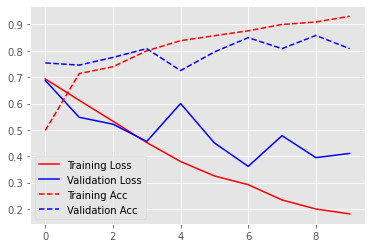

13/13 [==============================] - 2s 86ms/step - loss: 0.3401 - accuracy: 0.8675
Test acc: 0.868


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

model = keras.models.load_model("custom_attention.keras")
print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")

#*Transformer /w Multi-Head Attention Layer*

We can leverage the code from the book for a Transformer of course.

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
  
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs): # Dense dim is how many nodes in the dense layer projection. # Embed dimension is dim of embeddings.
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
  
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

We have max length of 2000 terms, and thus one-hot encodings means we have 

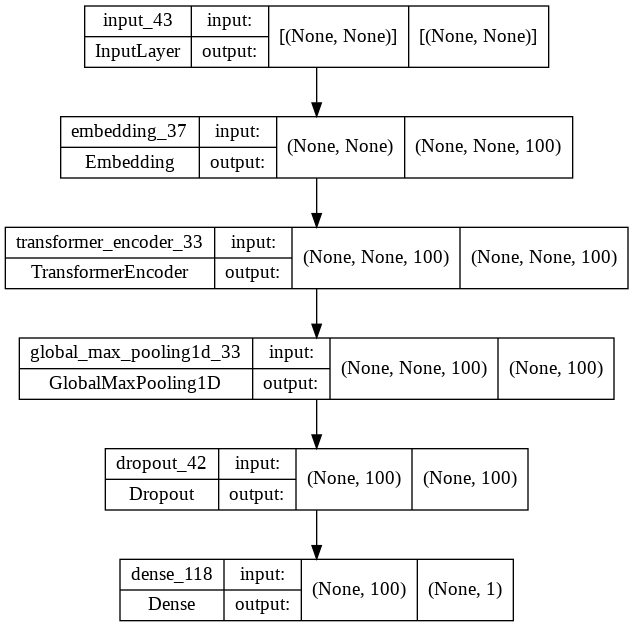

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
processed_text = text_vectorization(text_data)

vocab_size = len(vocabulary)
embed_dim = 100
num_heads = 2
dense_dim = 32 # How many dense nodes in the transformer Dense layer

def build_transformer():

    inputs = keras.Input(shape=(None,), dtype="int64")

    # This model will learn its own custom embedding layer.
    x = layers.Embedding(vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
    return model

model_transformer = build_transformer()
keras.utils.plot_model(model_transformer, show_shapes=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]

model_transformer = build_transformer()

history = model_transformer.fit(processed_text[:1200], labels_train, validation_split=0.2, batch_size=1,epochs=20, callbacks=callbacks)

Epoch 1/20
960/960 [==============================] - 6s 5ms/step - loss: 0.8182 - accuracy: 0.5135 - val_loss: 0.7158 - val_accuracy: 0.6000
Epoch 2/20
960/960 [==============================] - 4s 4ms/step - loss: 0.6087 - accuracy: 0.6823 - val_loss: 0.4992 - val_accuracy: 0.7500
Epoch 3/20
960/960 [==============================] - 4s 4ms/step - loss: 0.5277 - accuracy: 0.7406 - val_loss: 0.6369 - val_accuracy: 0.6792
Epoch 4/20
960/960 [==============================] - 4s 4ms/step - loss: 0.4596 - accuracy: 0.8000 - val_loss: 0.4052 - val_accuracy: 0.8042
Epoch 5/20
960/960 [==============================] - 4s 4ms/step - loss: 0.4049 - accuracy: 0.8281 - val_loss: 0.4889 - val_accuracy: 0.7792
Epoch 6/20
960/960 [==============================] - 4s 4ms/step - loss: 0.3278 - accuracy: 0.8760 - val_loss: 0.4416 - val_accuracy: 0.8292
Epoch 7/20
960/960 [==============================] - 4s 4ms/step - loss: 0.3146 - accuracy: 0.8854 - val_loss: 0.3915 - val_accuracy: 0.8208
Epoch 

And plotting loss over training, and checking loss against test set... this model actually does worse than our custom attention layer!

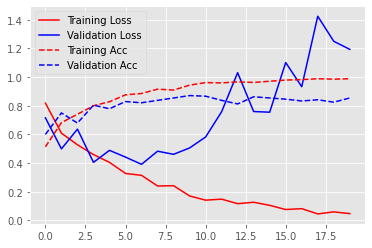

13/13 [==============================] - 1s 14ms/step - loss: 0.4204 - accuracy: 0.8175
Test acc: 0.817


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

model = build_transformer()
model.load_weights("transformer_encoder.keras")
print(f"Test acc: {model.evaluate(processed_text[1200:],labels_test)[1]:.3f}")

#*Transformer + Positional Embeddings*

A vanilla transformer architecture considers context, but not word order. It looks at what else is in the sequence, but not *where* those other things are. To account for this, we will implement an embedding layer that jointly constructs word-specific embeddings, in tandem with position-specific embeddings, before passing the summation to our transformer. Basically, learn a vector that applies to each sequence position that will 'apply' to the word-specific vector representations we learn, to shift them around depending on where in the sequence a word appeared. The transformer will thus learn what to pay attention to, considering all the tokens in the sequence AND where they appeared.

In [16]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
  
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
 
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

We will now include this up front embedding ahead of the transformer.

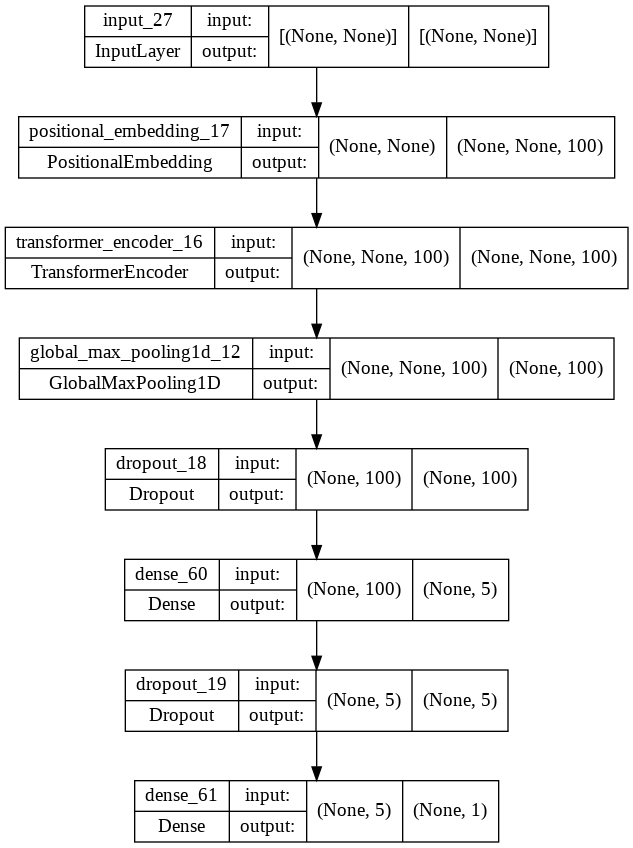

In [45]:
vocabulary = text_vectorization.get_vocabulary()
processed_text = text_vectorization(text_data)

vocab_size = len(vocabulary)
num_heads = 2
embed_dim = 100
dense_dim = 32 # How many dense nodes in the transformer Dense layer
seq_len = 784

def build_transformer():

    inputs = keras.Input(shape=(None,), dtype="int64")

    # This model will learn its own custom embedding layer.
    x = PositionalEmbedding(seq_len, vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
    return model

model_transformer = build_transformer()
keras.utils.plot_model(model_transformer, show_shapes=True)
  

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
] 
model.fit(one_hot[:1200], labels_train, validation_split=0.2, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding}) 
print(f"Test acc: {model.evaluate(one_hot[1200:],labels_test)[1]:.3f}")

Epoch 1/20
30/30 [==============================] - 5s 152ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.9514 - val_accuracy: 0.7625
Epoch 2/20
30/30 [==============================] - 5s 151ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.7270 - val_accuracy: 0.8500
Epoch 3/20
30/30 [==============================] - 4s 150ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6762 - val_accuracy: 0.8542
Epoch 4/20
30/30 [==============================] - 5s 152ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.5809 - val_accuracy: 0.7792
Epoch 5/20
30/30 [==============================] - 4s 150ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7009 - val_accuracy: 0.8333
Epoch 6/20
30/30 [==============================] - 4s 151ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.7045 - val_accuracy: 0.8417
Epoch 7/20
30/30 [==============================] - 4s 150ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.6567 - val_accuracy: 0.8458
Epoch 